# Assignment 5: Model Based Reinforcement Learning

### Due Date: 
Nov 26 at 11:59 PM 

### Writeup: 
https://docs.google.com/document/d/1PxXUYKqWdS1a9yF-o1UlY23QAlpu1qTrdoUfJfm6jlk/edit?usp=sharing 

## Introduction


Welcome to Assignment 5 of CS 4756/5756. In this assignment, you will explore the effects of model based reinforcement learning, while getting familiar with Stable Baselines, a popularly used reinforcement learning library. 

You will use the MountainCar-v0 environment for this assignment. Refer to the Gym website for more details about the [MountainCar environment](https://gymnasium.farama.org/environments/classic_control/mountain_car/).


**Structure of Assignment:** 
This assignment is built up by the following components: 
- Setting Up: dependency installing and initializations 
- Helper Functions: A set of provided helper functions for you to evaluate and visualize policies. 
- Part 1: Introduction to StableBaselines3 package. You will implement some helper classes and write some scripts to train a PPO agent with StableBaselines3. 
- Part 2: Collect data on the MountainCar environment transition and train a world model 

*Note: Bulk of implementation is in Part 1 and 2, building your foundation of helper functions and classes to use in Part 3.*

- Part 3: Train a learner PPO policy on the environment modeled in part 1 as world environment. 
- [GRAD] Part 4: Collect new data with learner policy and aggregate with expert collected data, repeat part 2 world model training and part 3 agent training. 


Please read through the following paragraphs carefully. 


**Getting Started:** You are free to complete this assignment on **either  [Google Colab](https://colab.research.google.com/) or your local machine**. Note that there will be a small amount of extra setup if you choose to complete the assignment on your local machine (see **Setup** section below).

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers, you are not expected to replicate them exactly). Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


## Set Up
As mentioned above, you are free to use Google Colab or your local machine for this assignment. Regardless of your choice, **you will need to run the cell below**. If you are using your local machine, though, you will first need to set up a conda environment that contains the packages found in requirements.txt.


### Setting Up Conda Environment (Local Machine Only)

In order to complete the assignment locally, you will need to install the required libraries. To do this, we will use the package manager [Conda](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html).

* First, create a Conda environment in the terminal with the correct version of python by running: `conda create --name cs4756_a5 python=3.10`
* Next, activate the environment by running: `conda activate cs4756_a5`
* Lastly, install the required libraries by runnning: `pip install -r requirements.txt`

When you run the notebook, make sure to set the Python interpreter and kernel to be the version of python from the `cs4756_a5` environment. If you are using VSCode, you may need to restart after creating the environment in order for `cs4756_a5` to be a visible option that you can select for your kernel.



In [1]:
# Set Up:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install -U renderlab
    !pip install -U colabgymrender
    !pip install -U moviepy==0.2.3.5
    !pip install imageio==2.4.1
    !pip install --upgrade AutoROM
    !AutoROM --accept-license
    !pip install gymnasium
    !pip install gym[classic_control] > /dev/null 2>&1
    
    !pip install stable_baselines3

import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from copy import deepcopy

from torch.utils.data import DataLoader
from torch import nn
import torch

from tqdm import tqdm, trange

seed = 24
data_seed = 700



## [PROVIDED] Helper Functions

### Reseed 

We provide the reseeding function that will update the seed to a given customary seed passed in as parameter. This helps reproducibility of the code and hopes to eliminate confusion on achieved number results for the rest of this assignment. 

An optional parameter of `env` is passed in, such that when one is provided, the function will also set the seed of the random number generator of that particular gym environment.

**Note**: All calls to this function will be given available to you for the rest of the assignment. 

In [2]:
# Setting the seed to ensure reproducability
def reseed(seed, env=None):
    '''
        Sets the seed for reproducibility 

        When @param env is provided, also sets the 
        random number generataor of the gym environment 
        to this particular seed
    '''
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    if env is not None: 
        env.unwrapped._np_random = gym.utils.seeding.np_random(seed)[0]

reseed(seed)

### Visualize

Below, we provide the helper function `visualize` for your use. This function will create a visualization of your specified environment by running an episode with the provided algorithm. If you are using Colab, calling this function will render the visualization within the notebook. If you are using your local machine, this function will instead save a video of the visualization to your current directory (rendering videos in Jupyter Notebooks is not widely supported outside of Colab). 

**Note** that in this code, a choice is provided on whether to vectorize the environment. The difference across vectorized and not vectorized gymnasium environments will be explained in the StableBaselines Introduction section. 

In [14]:
def visualize(env_name='MountainCar-v0', algorithm=None, video_name="test", env_args={}):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            env_name: Name of the gym environment to roll out `algorithm` in, it will be instantiated using gym.make or make_vec_env
            algorithm (PPOActor): Actor whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    if USING_COLAB:
        from renderlab import RenderFrame

        directory = './video'
        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        env = RenderFrame(env, directory)
        obs, info = env.reset()

        for i in range(200):
            action = get_action(obs)
            obs, reward, done, truncate, info = env.step(action)

            if done:
                break

        env.play()
    else:
        import cv2

        fourcc = cv2.VideoWriter_fourcc(*'H264')
        video = cv2.VideoWriter(f"{video_name}.mp4", fourcc, 24, (600,400))

        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        obs, info = env.reset()

        for i in range(500):
            action = get_action(obs)
            res = env.step(action)
            obs, reward, done, truncate, info = res

            if done:
                break

            im = env.render()
            im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

### Policy Evaluation function

The `evaluate_policy` function takes an agent actor, an environment whose output observations can be directly applied to the actor, and evaluates the policy by doing the following: 

- Rollout actor for a default of 100 trajectories, and record the total reward
- Return the average trajectory rewards over these episodes. 

**Note**: since the actor we will be defining in this assignment exclusively uses a StableBaselines3 PPO agent, then the environment provided must be an instance of `VecEnv`, more information introduced in Part 1. 

In [15]:
def evaluate_policy(actor, environment, num_episodes=100, progress=True): 
    '''
        Returns the mean trajectory reward of rolling out `actor` on `environment 

        Parameters 
        - actor: PPOActor instance, defined in Part 1 
        - environment: classstable_baselines3.common.vec_env.VecEnv instance 
        - num_episodes: total number of trajectories to collect and average over
    '''
    total_rew = 0 

    iterate = (trange(num_episodes) if progress else range(num_episodes))
    for _ in iterate: 
        obs = environment.reset() 
        done = False

        while not done: 
            action = actor.select_action(obs)
            
            next_obs, reward, done, info = environment.step(action) 
            total_rew += reward
            
            obs = next_obs 
    
    return (total_rew / num_episodes).item() 
        

## Introduction to the Mountain Car Environment

MountainCar-v0 is a classic control problem in the field of reinforcement learning. The task is to drive the cart up the hill and to the goal on the right. The environment consists of a cart that can move along a track that changes in elevation, starting a various possible positions on this track. The goal is to reach the top of hte hill. 

The observation space consists of two variables: position of the car along the x-axis, and the velocity of the car. The action space includes three discrete actions: accelerate the cart to the left, do not accelerate, and accelerate the cart to the right. An episode ends when the cart reaches the top or when it has taken over 200 steps.

**Run the cell below to visualize the MountainCar-v0 environment with a random policy:**

In [16]:
visualize(env_name='MountainCar-v0')

Video saved as test.mp4


## Part 1: Train an expert using StableBaselines3 



### Overview: Introduction to Stable Baselines 3

**Please Read Carefully**: Contains information necessary for following implementations. 

StableBaselines3 is popular off-the-shelf set of reliable implementations of reinforcement learning algorithms in PyTorch. 

In this assignment, we will be using its PPO (Proximal Policy Gradient) implementation as our agent. 

Each of the algorithm implementation is a subclass of the `stable_baselines3.common.base_class.BaseAlgorithm` class, which provides us with the following functions: 

- `learn(total_timesteps, callback=None, log_interval=100, tb_log_name='run', reset_num_timesteps=True, progress_bar=False)`: This is the training loop of any of the RL algorithm implementations. Training is done by calling this function with an appropriate amount of `total_timesteps` 
- `predict(observation)`: Returns a tuple `(predicted_action, next_hidden_state)` based on input `observation`. If we are not using an RNN, the next hidden state can be neglected. 
- `save(path)`: Saves the current policy parameters into a `.zip` file with given `path`. Note that the `path` does not have the `.zip` postfix. 
- `load(path, env=None)`: Loads a saved a `.zip` checkpoint into this RL implementation model. 

### [PROVIDED] Hyperparameters

There are a set of hyperparameters that can be tuned toward a better performance, for the sake of simplicity, we will provide the hyperparameters for the StableBaselines3 PPO implementation. The main ones we specify include the following: 
* `n_steps`: the number of steps to run with the environment for each update to the policy network
* `net_arch`: The network architecture of the policy network and the critic network: 
  * `pi`: a list that specifies the hidden dimensions of the policy network. The input and output dimension are determined by the environment associated with this policy 
  * `vf`: a list that specifies the hidden dimensions of the critic network. 
  * `activation_fn`: Nonlinearity to be applied between each of the MLP layers 

For a more comprehensive list and description of each of these hyperparameters, visit the official [documentation page](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters) for more information. 


In [6]:
# Dependencies:

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env.base_vec_env import VecEnv

hyperparameters = {
    "n_steps": 10000,
    "policy_kwargs": {
        "net_arch": {
            "pi": [32, 64, 32],
            "vf": [32, 64, 32],
            "activation_fn": "tanh",
        }
    },
}


### 1.1: Vectorized Environmnent (2 points)

#### Overview
For any StableBaselines3 algorithm implementation, any gymnasium environment used need to be converted into a [vectorized environment](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#) of `VecEnv` type. 

A vectorized environment stacks multiple independent environments into one, stepping multiple `n` environments each time. If we set the the `n_envs` parameter to 3, then 3 environments will be stepped each time the VecEnv is stepped. 

**For the rest of this assignment, all vectorized environments with n_env=n will be described as n-vectorized.** 

With a vectorized environment that steps multiple environments at the same time, the model learning process can be made more efficient through parallelization trajectory collection across these independent environments. This `n_envs` parameter can be tailored to the specific machines.  

**Import Note of Difference**: 
- The vectorized environments now require input action to be a shape of `n_envs * act_dim`. The output observation from `step` and `reset` will also have the shape of `n_envs * obs_dim`
- The VecEnv `reset()` function returns only the observation, while the gymnasium.Env `reset()` function returns a tuple `(observation, info_dict)` 
- The `vec_env.step(action)` function returns a 4-tuple of `(obs, reward, terminated, info)`, while the `gym_env.step(action)` returns a 5-tuple of `(obs, reward, terminated, truncated, info)`. The `terminated` value from VecEnv would equivalent to the gymnasium environment's `terminated or truncated` 

 
A VecEnv instance can be created using the `make_vec_env` function, which takes the id of the wanted gymnasium environment, as well as the number of environments needed. This function has the following key parameters 
- `env_id`: required parameter that is the id of the gymnasium environment, or instantiated gym environment, or a callable that returns an env. 
- `n_envs`: The number of environments to have in parallel 
- `seed`: The initial seed for the random number generator (This parameter is only here to explain its purpose, for the actual code DO NOT use this parameter)
- `env_kwargs`: An optional parameter to pass into the environment constructor. 

More detailed function documentation can be found in this [page](https://stable-baselines3.readthedocs.io/en/master/common/env_util.html#stable_baselines3.common.env_util.make_vec_env). 

#### Instructions 
For this part, please create two vectorized version of MountainCar-v0 with 3 and 1 environments stacked

In [7]:
from stable_baselines3.common.env_util import make_vec_env

# TODO: 
real_vec_env_3 = make_vec_env('MountainCar-v0', n_envs=3)
real_vec_env_1 = make_vec_env('MountainCar-v0', n_envs=1)
# END TODO

### 1.2: Actor Definition (3 points)

**Instruction**: You will need to implement the following PPOActor class, which serves as a wrapper to provide PPO model predictions. 
- `__init__`: Takes a path to the checkpoint and the corresponding environment, and load an instance of this PPO checkpoint. However if a PPO model is given, then the internally representing model uses that directly instead. This is for use in the Callback function, and since we provide that implementation for you, you will only need to implement the model loading portion of the constructor. 

**Note**: the environment being passed is usually be the 3-vectorized corresponding environment later in the program, but they will not be used by the actor other than initializing the model. 
  
- `select_action`: Takes an observation and produce the corresponding action prediction from the checkpoint PPO model. While implementing, take note of the output of the `predict` function. 

In [8]:
class PPOActor():
    def __init__(self, ckpt: str=None, environment: VecEnv=None, model=None):
        '''
          Requires environment to be a 1-vectorized environment

          The `ckpt` is a .zip file path that leads to the checkpoint you want 
          to use for this particular actor.  
          
          If the `model` variable is provided, then this constructor will store
          that as the internal representing model instead of loading one from the 
          checkpoint path
          
        '''
        assert ckpt is not None or model is not None
        if model is not None: 
            self.model = model 
            return 
        
        # TODO: MODIFY
        self.model = PPO.load(ckpt, environment)
        # End TODO 
         
    
    def select_action(self, obs):
        '''
          Gives the action prediction of this particular actor 
        '''
        # TODO:
        return self.model.predict(obs)[0]
        # END TODO


### 1.3: [PROVIDED] Callbacks

To visualize the training process, since it could take a significant amount of time, StableBaselines3 provides a mean for us to visualize the training progress through a BaseCallback class instance, which can be optionally passed in as a parameter of the `learn` function. This Callback function is customizable by defining a subclass of `BaseCallback`. 

For this part, we provide you with a customized callback that evaluates the model under training every 120000 steps on an evaluating environment, which will be the 1-vectorized environment you have instantiated in the previous portion. Based on this evaluation result, this callback will save a checkpoint of the model if it is, so far, the best performing model. At the end of training, a plot of all evaluation results with respect to number of steps will be generated. 

You are free to modify this callback class to help you visualize training in any way most convenient for you, but is **NOT REQUIRED**. 

In [213]:
class PPOCallback(BaseCallback):
    def __init__(self, verbose=0, save_path='default', eval_env=None):
        super(PPOCallback, self).__init__(verbose)
        self.rewards = []

        self.save_freq = 120000
        self.min_reward = -np.inf
        self.actor = None
        self.eval_env = eval_env 
        
        self.save_path = save_path

        self.eval_steps = []
        self.eval_rewards = [] 

    def _init_callback(self) -> None:
        pass 

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        
        self.actor = PPOActor(model=self.model)

    def _on_rollout_start(self) -> None: 
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass 

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """

        episode_info = self.model.ep_info_buffer
        rewards = [ep_info['r'] for ep_info in episode_info]
        mean_rewards = np.mean(rewards)

        self.rewards.append(mean_rewards)
        

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        if self.eval_env is None: 
            return True 

        if self.num_timesteps % self.save_freq == 0 and self.num_timesteps != 0: 
            mean_reward = evaluate_policy(self.actor, environment=self.eval_env, num_episodes=20) 
            print(f'evaluating {self.num_timesteps=}, {mean_reward=}=======')

            self.eval_steps.append(self.num_timesteps)
            self.eval_rewards.append(mean_reward)
            if mean_reward > self.min_reward: 
                self.min_reward = mean_reward 
                self.model.save(self.save_path)
                print(f'model saved on eval reward: {self.min_reward}')
        
        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        print(f'model saved on eval reward: {self.min_reward}')

        plt.plot(self.eval_steps, self.eval_rewards, c='red')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')

        plt.show()
        plt.close()


### 1.4 PPO Expert Initialization and Training (2 points)

#### Overview

The `stable_baselines3.ppo.PPO` class inherits from the `BaseAlgorithm` class described at the beginning of this section, and is specifically implemented for the PPO algorithm. To initialize a class, the following parameters are especially important: 
- `policy: str`: The policy type we use to train the agent, common ones include MlpPolicy and CnnPolicy. In our case, we will be using the MlpPolicy. 
- `env: VecEnv`: The environment that the agent rollouts on for training, must be vectorized or it will be vectorized by the PPO implementation 
- `n_steps`: number of steps to optimize the policy for 
- `device`: The device to put the model on (For this assignment, if you're not able to reach the performance bounds, try setting this parameter to cpu)
- Other hyperparameters specified in the `hyperparameters` dictionary we provided, can be directly applied using the \*\* operator. 

#### Instructions 
- Initialize a PPO MLP policy as expert, using the 3-env VecEnv initialized in the previous part and pass in the given hyperparameters. 
- Train the expert with an instance of the `PPOCallback` defined before. No need to save the resulting model into checkpoint since that is done for you in the Callback class
    
    (HINT): Look at the beginning of Part 1 for useful functions for training. 


**Estimated Training Time**: 
- 10 minutes on a Mac M1 CPU
- 30 minutes on Google Colab CPU 

Using cpu device


c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 30000`, after every 468 untruncated mini-batches, there will be a truncated mini-batch of size 48
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=10000 and n_envs=3)
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


evaluating self.num_timesteps=120000, mean_reward=-200.0=======
model saved on eval reward: -200.0


100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


evaluating self.num_timesteps=240000, mean_reward=-200.0=======


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


evaluating self.num_timesteps=360000, mean_reward=-200.0=======


100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


evaluating self.num_timesteps=480000, mean_reward=-194.85000610351562=======
model saved on eval reward: -194.85000610351562


100%|██████████| 20/20 [00:01<00:00, 12.82it/s]


evaluating self.num_timesteps=600000, mean_reward=-161.60000610351562=======
model saved on eval reward: -161.60000610351562


100%|██████████| 20/20 [00:01<00:00, 14.68it/s]


evaluating self.num_timesteps=720000, mean_reward=-129.5500030517578=======
model saved on eval reward: -129.5500030517578


100%|██████████| 20/20 [00:01<00:00, 16.00it/s]


evaluating self.num_timesteps=840000, mean_reward=-111.75=======
model saved on eval reward: -111.75


100%|██████████| 20/20 [00:01<00:00, 18.86it/s]


evaluating self.num_timesteps=960000, mean_reward=-105.3499984741211=======
model saved on eval reward: -105.3499984741211


100%|██████████| 20/20 [00:01<00:00, 19.24it/s]


evaluating self.num_timesteps=1080000, mean_reward=-105.0=======
model saved on eval reward: -105.0


100%|██████████| 20/20 [00:01<00:00, 19.22it/s]


evaluating self.num_timesteps=1200000, mean_reward=-98.8499984741211=======
model saved on eval reward: -98.8499984741211


100%|██████████| 20/20 [00:01<00:00, 18.35it/s]


evaluating self.num_timesteps=1320000, mean_reward=-104.0999984741211=======


100%|██████████| 20/20 [00:01<00:00, 19.26it/s]


evaluating self.num_timesteps=1440000, mean_reward=-99.94999694824219=======
model saved on eval reward: -98.8499984741211


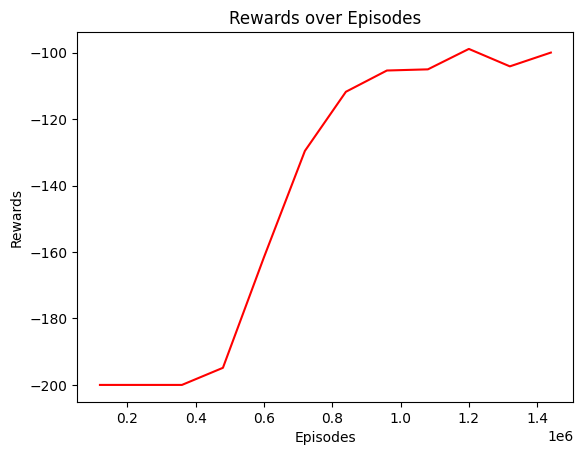

In [13]:

ckpt_path = 'expert'
total_steps = 1500000

reseed(seed) 
expert_callback = PPOCallback(save_path=ckpt_path, eval_env=real_vec_env_1)

# TODO

expert_actor = PPO('MlpPolicy', real_vec_env_3, verbose=1, **hyperparameters)
expert_actor.learn(total_steps, callback=expert_callback, log_interval=100)

# END TODO

### 1.5: Evaluate Expert (2 points)

Initialize an expert PPOActor instance and evaluate the expert agent using the `evaluate_policy` function on the real environment. 

**Expected Reward**: Around -130 to -100

In [215]:
# TODO: MODIFY
expert = PPOActor('expert', real_vec_env_3)

print(evaluate_policy(expert, real_vec_env_1, num_episodes=20))

# END TODO

100%|██████████| 20/20 [00:01<00:00, 19.33it/s]

-99.55000305175781


### 1.6: [PROVIDED] Visualize Expert

In [17]:
visualize(algorithm=expert, video_name='expert')

Video saved as expert.mp4


## Part 2: Collect Data and Train World Model

### Overview: 
Unlike in simulation, we can rarely obtain the full transition function of real world scenarios, and we emulate that property in this assignment here. 

Assuming we do not have the underlying logic to the MountainCar-v0, given that we have an expert agent in solving this particular problem, we take the following modeled based reinforcement learning approach to learn an RL agent that can be applied to the real scenario. 

In real life, we might not have such a trained expert, and human operating the robot remotely could be one source of expert data. 

1. Rollout a series of expert trajectories in the true environment (analogous to collecting a set of human demonstrations on the robot) 
2. Define and train a world model with the trajectory transitions as input data
3. Define a new environment that applies the trained world model
4. Learn an RL agent under the learned environment
5. Evaluate this agent using the real environment

### Instructions

You will need to implement the following functions and classes 
- `data_collect`: a helper function that rolls out a policy on an environment, and returning a tuple of lists representing the transitions 
- `WorldModel` : a `torch.nn` module defining the architecture of the world. 
- `train_world_model` and `eval_world_model`: Training and evaluation loop of the world model

Follow the instructions below to implement each of these components

### 2.1: Collect Data

#### data_collect function (6 points)
**Instructions**: 

The `data_collect` function should rollout a policy actor on the environment for a total of `num_steps`, with a maximum trajectory length of `traj_max_length`, then returning 3 lists: `observations`, `actions`, `next_observations` such that for any transition $i \leq$ num_steps: 

data_env with intiial state `observations[i]`, when stepped with `actions[i]`, yields a new state `next_observations[i]`. 

In [196]:
def data_collect(num_steps: int, traj_max_length: int, data_env: gym.Env, actor: PPOActor):
    '''
    Collects observation, action, next_observation triplet data for `num_trajectories`
    each with a maximimum step count of `traj_max_length`

    - num_steps: Number of total steps to collect data over, should also be the sum of trajectory lengths
    - traj_max_length: Maximum length of each trajectory
    - data_env: The environment to collect data under, NOT A VECENV

    - actor: A function that takes a `data_env` observation as input and outputs an action admissible to `data_env`

    Returns: (observations, actions, next_observations), each being a list
    '''
    
    observations, actions, next_obs = [], [], []
    
    # TODO: 

    steps = 0
    while steps < num_steps: 
        obs = np.array(data_env.reset()[0])
        done = False
        trajectory_steps = 0
        while not done and trajectory_steps < traj_max_length: 
            action = actor.model.predict(obs)
            new_obs, reward, terminated, truncated, info = data_env.step(action[0])
            done = terminated or truncated
            observations.append(obs)
            actions.append(action[0]) 
            next_obs.append(new_obs)
            
            obs = new_obs
            steps += 1
            trajectory_steps += 1
            
            if steps >= num_steps: 
                break

    

    # END TODO
    return observations, actions, next_obs



[Provided] function that visualizes collected data

In [197]:
def visualize_collected_data(observations, next_obs): 
    '''
        Takes the first 300 data points and generates a 
        plot of the observations and next_obs. 
    '''
    print(f'Dataset Size: {len(observations)}')
    plt.close()
    plt.plot(np.arange(300), observations[:300], c='blue')
    plt.plot(np.arange(300), next_obs[:300], c='red')
    plt.show()

#### Run Data Collection (1 point) 

**Instruction**: 
Run data collection function on the real policy with expert policy trained in part 1. 

**Note**: the `data_collect` function requires the environment provided to be a regular gymnasium environment instead of a vectorized environment. Please make sure to not confuse it with `real_vec_env_1` defined in part 1.1. 

**Note**: Here is a list of currently created environments after running this following cell: 
- `real_vec_env_1` 
- `real_vec_env_3` 
- `real_env` 

Refer to function documentation for selecting which one to use when doing function calls. 

Dataset Size: 100000


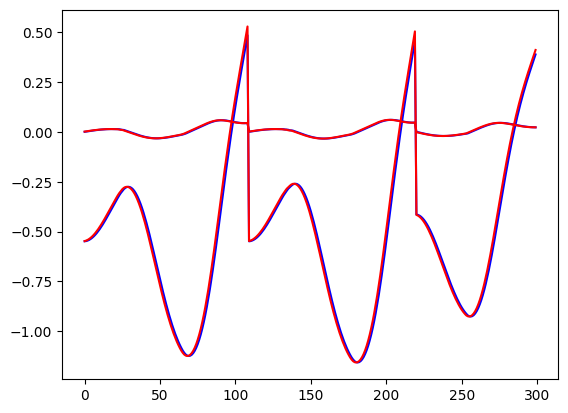

In [198]:
total_steps = 100000
# total_steps = 1000
traj_max_length = 500

real_env = gym.make('MountainCar-v0', render_mode='rgb_array')

reseed(data_seed, env=real_env) 

# TODO: MODIFY to run data collect function to collect data
observations, actions, next_obs = data_collect(total_steps, traj_max_length, real_env, expert)
actions = np.array(actions)[:,np.newaxis]
# END TODO 

visualize_collected_data(observations, next_obs)


[PROVIDED]: Defining the torch dataset and dataloader used for training. 

In [199]:
from torch.utils.data import Dataset
class WorldDataset(Dataset):
    def __init__(self, obs, actions, next_obs):
        self.obs = obs
        self.actions = actions
        self.next_obs = next_obs
        
    def __len__(self):
        return len(self.obs)

    def __getitem__(self, idx):
        return {
            'orig_obs': self.obs[idx],
            'action': self.actions[idx],
            'next_obs': self.next_obs[idx]
        }

split = len(observations) // 5

val_data = WorldDataset(observations[:split], actions[:split], next_obs[:split])
train_data = WorldDataset(observations[split:], actions[split:], next_obs[split:])

train_dataloader = DataLoader(train_data, batch_size=128)
val_dataloader = DataLoader(val_data, batch_size=128)

### 2.2: Define World Model (3 points)

The `WorldModel` class should define a neural network that takes a state-action pair and outputs a state in the state space. The network should have the following architecture. 

- Layer 1: a fully-connected layer with `inp_dim` input nodes and `hidden_dim_1` output nodes, followed by a ReLU activation function.
- Layer 2: a fully-connected layer with `hidden_dim_1` input nodes and `hidden_dim_2` output nodes, followed by a ReLU activation function.
- Output layer: a fully-connected layer with `hidden_dim_2` input nodes and `output_dim` output nodes. 

The `forward` function should take two inputs: `state` and `action`, concatenate them along the last dimension, and then pass it through the model architecture. For instance, if the state has shape `n * s`, and the action has shape $n \times a$, then the input to the model should be `n * (s + a)`


In [200]:
class WorldModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(WorldModel, self).__init__()
        self.input_dim = input_dim 

        # TODO: 
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)

        # END TODO  

    def forward(self, state, action):
        '''
            Expected `state` to have shape n * s_dim 
            Expected `action` to have shape n * a_dim
        '''
        n, s_dim = state.shape 
        n_a, a_dim = action.shape 
        assert n == n_a
        assert s_dim + a_dim == self.input_dim
        
        # TODO: MODIFY

        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x
        # END TODO
    

### 2.3: Define Training and Validation Function for World Model (12 points, 6 each): 

The `train_world_model` function should train the provided model for one epoch, using the optimizer and criterion provided on the given train_dataloader. This function should iterate through each batch of the `train_dataloader` once, update the world model based on the loss calculated by criterion, then step the optimizer. 

The `eval_world_model` function is similar to the `train_world_model` function with iteration through the batches of the `eval_dataloader` and computes the loss using the given criterion. Note that no update to model should be made and gradients should not be calculated during the forward pass. 

In [201]:
def train_world_model(model, optimizer, criterion, train_dataloader):

    '''
        This function should train the torch model `model` using the 
        optim `optimizer` and `criterion` as loss function, on one pass 
        of the `train_dataloader` 

        This is should train the model for on epoch, as in one pass through
        the training data. 

        Returns: the mean criterion loss across each batch of the dataset. 
    '''
    # TODO: 

    model.train() 
    total_loss = 0 
    for data in train_dataloader: 
        optimizer.zero_grad() 
        orig_obs = data['orig_obs'] 
        action = data['action']
        next_obs = data['next_obs'] 
        pred = model(orig_obs, action)
        loss = criterion(pred, next_obs) 
        loss.backward() 
        optimizer.step() 
    total_loss += loss.item() 
    return total_loss / len(train_dataloader)

    # END TODO

def eval_world_model(model, criterion, eval_dataloader):
    '''
        This function should evaluate the torch model `model` using 
        `criterion` as loss function, on one pass of the `eval_dataloader` 

        This is should evaluate the model on the validation dataset. 

        Take note that during evaluation, the model should not be updated 
        in any way and gradients should not be calculated. 

        Returns: the mean criterion loss across each batch of the dataset. 

    '''
    # TODO: 

    model.eval()
    total_loss = 0
    for data in eval_dataloader: 
        orig_obs = data['orig_obs']
        action = data['action']
        next_obs = data['next_obs']

        pred = model(orig_obs, action)
        loss = criterion(pred, next_obs)

        total_loss += loss.item()

    return total_loss / len(eval_dataloader)

    # END TODO: 

### 2.4: Train the World Model (3 points)

Train an instance of `WorldModel` for 50 epochs with the dataloader built in previous section, using Adam optimizer and MSE loss, with an lr of 0.0001. 

Provide a plot of training and evaluation losses with respect to training epochs.

100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


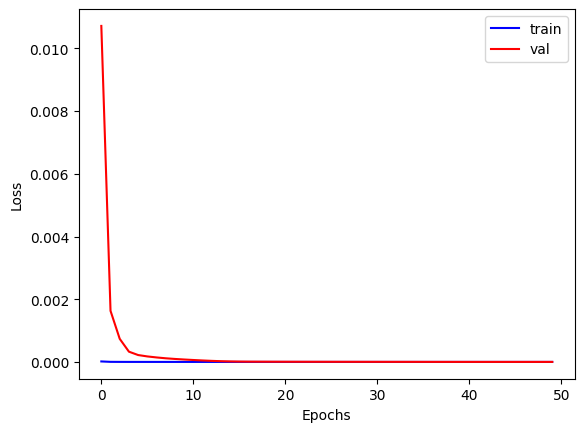

In [202]:
num_epochs = 50

reseed(seed)

world_model = world_model = WorldModel(input_dim=3, hidden_dim_1=16, hidden_dim_2=128, output_dim=2)
lr = 0.0001
optimizer = torch.optim.Adam(world_model.parameters(), lr=lr)
criterion = nn.MSELoss()


# TODO

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)): 
    train_loss = train_world_model(world_model, optimizer, criterion, train_dataloader)
    val_loss = eval_world_model(world_model, criterion, val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot(np.arange(num_epochs), train_losses, c='blue', label='train')
plt.plot(np.arange(num_epochs), val_losses, c='red', label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# END TODO: 


In [216]:
print("Validation Loss: ", val_losses[-1])

Validation Loss:  3.7057205621138587e-07


### 2.5: [PROVIDED] Build Gym Environment with World Model

The following `WorldModelEnv` class is largely defined for you to train your next PPO agent as the reinforcement learning component of MBRL. 

In this environment, the reward is calculated the same as the MountainCar-v0 gymnasium environment, with a -1 for each step that the car has not reached the goal. 


**To Initialize** a `WorldModelEnv` environment, a `world_model` (an instance of WorldModel in this case) should be passed in as argument, which will be used as the transition function in the `step()` function. 

This environment is registered with an id of **WorldModelMountainCar**, which can be initialized using `gym.make` or directly initializing it. 


**Run the following cell to define and register this environment** 

In [203]:
class WorldModelEnv(gym.Env):
    def __init__(self, world_model: WorldModel, render_mode: str='rgb_array'):
        super(WorldModelEnv, self).__init__()
        self.world_model = world_model
        self.corr_env = gym.make('MountainCar-v0', render_mode=render_mode).unwrapped

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=np.array([-1.2,  -0.07]), high=np.array([0.6, 0.07]), shape=(2,), dtype='float32')
        self.metadata = {
            'render_modes': ['human', 'rgb_array']
        }
        self.render_mode = 'rgb_array'

        self.state = np.array([np.random.rand(1).item() * 0.2 - 0.6, 0])

        self.min_action, self.max_action = -1.0, 1.0
        self.goal_position = 0.45

        self.step_count = 0

        
    def seed(self, seed=None):
        pass


    def reset(self, seed=None):
        self.state = np.array([np.random.rand(1).item() * 0.2 - 0.6, 0])
        self.step_count = 0
        self.corr_env.reset()
        return self.state, {}

    def step(self, action):
        with torch.no_grad():
            state = torch.from_numpy(self.state).float().unsqueeze(0) 
            action = torch.from_numpy(np.array([action])).unsqueeze(0)
            next_state = self.world_model(state, action)
            next_state = np.array(next_state.squeeze(0))
            self.state = np.clip(next_state, a_min=np.array([-1.2, -0.07]), a_max=np.array([0.6, 0.07]))
        self.step_count += 1

        terminated = bool(self.state[0] >= self.goal_position)

        # truncate = False
        truncate = bool(self.step_count > 2999)
        reward = -1
        return self.state, reward, terminated, truncate, {}

    def render(self):
        self.corr_env.state = (self.state[0], self.state[1])
        returned = self.corr_env.render()
        return returned


gym.register(id='WorldModelMountainCar', entry_point=WorldModelEnv)


### 2.6: Visualize World Model with Trained Expert

In [204]:
visualize(
    env_name='WorldModelMountainCar',
    algorithm=expert,
    video_name='expert_trained_world',
    env_args={
        'world_model': world_model
    },
)

c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.war

Video saved as expert_trained_world.mp4


## Part 3: Train a PPO agent on the Learned World Mode

### Overview 

Now that we have learned a model that simulates the transition function of the real environment, it's time to train an agent on this model. 

### Instruction 

In this part, you will learn, visualize, and evaluate a PPO policy on the learned world model, similar to what happened in Part 1, using functions defined in the Helper Function section, Part 1, and Part 2. 

**Follow instructions to complete each component**

### 3.1: Train New PPO on learned world environment (4 points)

**TODO 1 Instruction**: Initialize a 3-vectorized and a 1-vectorized WorldModelMountainCar environment. 

**TODO 2 Instruction**: For this part, we will train a separate PPO policy using the learned model environment. This model should be trained with the world model learned in the previous part for 1500000 steps, under a 3-vectorized environment, using the same hyperparameters provided in Part 1. 


**Note**: Here is a list of created environments after running this following cell: 
- `real_vec_env_1` 
- `real_vec_env_3` 
- `real_env` 
- `world_vec_env_1` 
- `world_vec_env_3`

Refer to function documentation for selecting which one to use when doing function calls. 


In [ ]:
learner_ckpt_path = 'learner'
total_steps = 1500000

seed = 937 
reseed(seed)

# TODO 1:
env_name = 'WorldModelMountainCar'
env_args = {'world_model': world_model}
world_vec_env_1 = make_vec_env(env_name, n_envs=1, env_kwargs=env_args)
world_vec_env_3 = make_vec_env(env_name, n_envs=3, env_kwargs=env_args)
# END TODO

learner_callback = PPOCallback(save_path=learner_ckpt_path, eval_env=world_vec_env_1)

# TODO 2: 

learner = PPO('MlpPolicy', world_vec_env_3, verbose=1, **hyperparameters)
learner.learn(total_steps, callback=learner_callback, log_interval=100)

# END TODO


c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


TypeError: DummyVecEnv.__init__() got an unexpected keyword argument 'world_model'

### 3.2: [PROVIDED] Visualize Policy with Learned World Model and Real Environment

In [217]:
learner_actor = PPOActor(ckpt=f'{learner_ckpt_path}.zip', environment=world_vec_env_1)
visualize(
    env_name='WorldModelMountainCar',
    algorithm=learner_actor,
    env_args={
        'world_model': world_model
    },
    video_name="learner",
)

visualize(
    env_name='MountainCar-v0',
    algorithm=learner_actor,
    video_name="learner_eval",
)


c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\zchos\anaconda3\envs\cs4756_a5\lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.war

Video saved as learner.mp4
Video saved as learner_eval.mp4


### 3.3: Evaluate Learned Policy (2 points) 

Evaluate the learner agent on both the learned world model and the MountainCar-v0 environment, take note of the numbers, and analyze them in the write up. 

**Expected Rewards**: 
- About -160 to -200 on MountainCar-v0
- About -30 to -100 on WorldModelMountainCar


In [219]:
learner_actor = PPOActor(ckpt=f'{learner_ckpt_path}.zip', environment=world_vec_env_1)

# TODO: 

print(evaluate_policy(learner_actor, world_vec_env_1, num_episodes=20))
print(evaluate_policy(learner_actor, real_vec_env_1, num_episodes=20))

# END TODO: 


100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


-3000.0


100%|██████████| 20/20 [00:01<00:00, 10.14it/s]

-200.0


## Part 4 (CS 5756 Question)

### 4.1: Collect Data with policy trained on world model (1 point)

In this section, we collect another 100000 steps of data with the learned agent from the previous part on the real environment, simulating rollouts of the learned agent in real world. 

In [ ]:
real_env = gym.make('MountainCar-v0', render_mode='rgb_array')
reseed(data_seed, real_env)

# TODO: 
policy_obs, policy_acts, policy_next_obs = None 
# END TODO

visualize_collected_data(policy_obs, policy_next_obs)

### 4.2: Aggregate Data (3 point)

**Instruction**: Aggregate the expert data collect in Part 2 and the agent data collected from previous section, shuffle their order, and form a new train/val split instances of the `WorldDataset` and dataloaders. 
- The train / val split should be 80% / 20% 

In [ ]:
# TODO: 

# END TODO


### 4.3: Train a second WorldModel using the new aggregated data (3 points)

- Train for 50 epochs with lr=0.0001, Adam optimizer, and MSELoss criterion. 
- Save the train and validation losses across epochs and plot them 

In [ ]:
num_epochs = 50
reseed(seed)

agg_world_model = WorldModel(input_dim=3, hidden_dim_1=16, hidden_dim_2=128, output_dim=2)
lr = 0.0001
agg_optimizer = torch.optim.Adam(agg_world_model.parameters(), lr=lr)
agg_criterion = nn.MSELoss()


# TODO: 

# END TODO

Visualize the resulting model through expert

In [ ]:
# visualize on trained expert
visualize(
    env_name='WorldModelMountainCar',
    algorithm=expert,
    video_name='expert_agg_trained_world',
    env_args={
        'world_model': agg_world_model
    },
)


### 4.4: Train new PPO policy on world model from 4.3 (4 points)

**TODO 1 Instruction**: Initialize a 3-vectorized and a 1-vectorized WorldModelMountainCar environment with the world model trained on aggregated dataset

**TODO 2 Instruction**: Train a separate PPO policy using the world model learned on aggregated data. Similar as before, this model should be trained for 1500000 steps, under a 3-vectorized environment, using the same hyperparameters provided in Part 1. 

**Note**: Here is a list of created environments after running this following cell: 
- `real_vec_env_1` 
- `real_vec_env_3` 
- `real_env` 
- `world_vec_env_1` 
- `world_vec_env_3`
- `agg_world_vec_env_1` 
- `agg_world_vec_env_3`

Refer to function documentation for selecting which one to use when doing function calls. 


In [ ]:
agg_ckpt_path = 'agg_learner'
total_steps = 1500000

reseed(seed) 

# TODO 1: 
agg_world_vec_env_3 = None
agg_world_vec_env_1 = None
# END TODO 

policy_callback = PPOCallback(save_path=agg_ckpt_path, eval_env=agg_world_vec_env_1)

# TODO : 

# END TODO



### Evaluate the aggregated PPO Agent on both real environment and learned world environment (2 points)  

**Expected Rewards** 
- About -120 to -150 on MountainCar-v0 
- About -100 to -140 on learned environment

In [ ]:
agg_learner_actor = PPOActor(ckpt='agg_learner.zip', environment=agg_world_vec_env_3)

# TODO: 

# END TODO